# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
!pip install -q seaborn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
!pip install -q fairlearn

import warnings
warnings.simplefilter(action='ignore', category='PerformanceWarning')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Prepare Dataset

In [4]:
import os
import cv2
import numpy as np
import pandas as pd

def extract_info(image_name: str, path: str) -> dict:
    """
    Extracts information from image name and returns a dictionary with the extracted features.
    """
    # Split the image name by underscore
    parts = image_name.split("_")
    
    # Check if the image name is valid
    if len(parts) < 4:
        return None
    
    # Extract the features
    age = int(parts[0])
    gender = "Male" if parts[1] == "0" else "Female"
    ethnicity_map = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}
    ethnicity = ethnicity_map.get(int(parts[2]))
    
    # Check if the ethnicity is valid
    if ethnicity is None:
        return None
    
    # Read and resize the image
    image = cv2.imread(path + image_name, 0)
    image = cv2.resize(image, dsize=(64, 64))
    
    # Create a dictionary with the extracted features and image data
    features = {"Age": age, "Gender": gender, "Ethnicity": ethnicity, "Image": image}
    
    return features

# Set the path to the directory containing the images
path = "/kaggle/input/utkface-new/UTKFace/"

# List all image files in the directory
image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]

# Extract the features from all image names
features_list = [extract_info(image_name, path) for image_name in image_files]

# Filter out invalid image names
features_list = [features for features in features_list if features is not None]

# Create a DataFrame with the extracted features
df = pd.DataFrame(features_list)

# Display the resulting DataFrame
df


,Age,Gender,Ethnicity,Image
0,26,Male,Asian,"[[8, 4, 6, 2, 7, 5, 19, 76, 142, 162, 178, 184..."
1,22,Female,Black,"[[4, 2, 0, 2, 7, 9, 9, 14, 18, 22, 29, 34, 38,..."
2,21,Female,Indian,"[[39, 35, 38, 34, 31, 27, 22, 21, 21, 28, 33, ..."
3,28,Male,White,"[[109, 121, 123, 121, 125, 129, 137, 148, 155,..."
4,17,Female,Others,"[[110, 124, 134, 145, 158, 168, 172, 180, 183,..."
...,...,...,...,...
23700,41,Male,White,"[[47, 50, 58, 68, 89, 97, 103, 101, 102, 105, ..."
23701,42,Male,White,"[[216, 199, 200, 175, 140, 123, 114, 90, 85, 7..."
23702,2,Male,Asian,"[[190, 191, 190, 191, 193, 195, 199, 199, 201,..."
23703,65,Female,White,"[[112, 135, 137, 113, 127, 164, 161, 165, 161,..."


In [5]:
# Scaling
df['Image'] = df['Image'] / 255

# 1st Model: For Feature Extraction

In [6]:
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate
from keras.models import Model

# For Feature Extraction
inputs_cnn = Input(shape=(64,64,1))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs_cnn)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs_dense = Dense(1)(x)



In [7]:
# Data Splitting
X = df.drop('Age',axis=1)
y = df['Age'].copy()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

x_train_images = np.stack(x_train['Image'].values)
x_test_images = np.stack(x_test['Image'].values)

In [8]:
# Training the Model
inputs_cnn = Input(shape=(64,64,1))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs_cnn)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs_dense = Dense(1)(x)

cnn_model = Model(inputs=inputs_cnn, outputs=outputs_dense)
optimizer = Adam()
cnn_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
history = cnn_model.fit(x_train_images, y_train.values, validation_data=(x_test_images, y_test.values), epochs=25, batch_size=128)

Epoch 1/25


2023-10-16 12:02:12.282317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


149/149 [==============================] - 12s 32ms/step - loss: 19.8001 - mean_absolute_error: 19.8001 - val_loss: 18.1383 - val_mean_absolute_error: 18.1383
Epoch 2/25
149/149 [==============================] - 4s 27ms/step - loss: 16.0709 - mean_absolute_error: 16.0709 - val_loss: 11.7517 - val_mean_absolute_error: 11.7517
Epoch 3/25
149/149 [==============================] - 4s 27ms/step - loss: 14.0336 - mean_absolute_error: 14.0336 - val_loss: 10.6044 - val_mean_absolute_error: 10.6044
Epoch 4/25
149/149 [==============================] - 4s 27ms/step - loss: 12.8923 - mean_absolute_error: 12.8923 - val_loss: 10.1868 - val_mean_absolute_error: 10.1868
Epoch 5/25
149/149 [==============================] - 4s 28ms/step - loss: 12.0871 - mean_absolute_error: 12.0871 - val_loss: 8.5224 - val_mean_absolute_error: 8.5224
Epoch 6/25
149/149 [==============================] - 4s 27ms/step - loss: 11.7068 - mean_absolute_error: 11.7068 - val_loss: 11.5413 - val_mean_absolute_error: 11.541

## Extracting the CNN Features

In [9]:
intermediate_layer_model = Model(inputs=cnn_model.input,
                                 outputs=cnn_model.get_layer(index=-8).output)
intermediate_output = intermediate_layer_model.predict(x_train_images)
intermediate_output_test = intermediate_layer_model.predict(x_test_images)
intermediate_output.shape

149/149 [==============================] - 0s 1ms/step


(18964, 25088)

In [10]:
x_train.drop('Image',inplace=True,axis=1)
x_test.drop('Image',inplace=True,axis=1)
del x_train_images, x_test_images

## Reducing the Dimensolinality of The CNN Features

In [11]:
from sklearn.decomposition import PCA
p_comp = 8
pca = PCA(n_components=p_comp, random_state=42)
x_train[[f'PCA{x}' for x in range(0,8)]] = pca.fit_transform(intermediate_output).copy()
x_test[[f'PCA{x}' for x in range(0,8)]] = pca.transform(intermediate_output_test).copy()
del intermediate_output, intermediate_output_test

# 2nd Model: Predicting Age Group (CNN features + Gender and Ethnicity)

In [12]:
# x_train = pd.read_csv('/kaggle/input/results-data/x_train.csv')
# y_train = pd.read_csv('/kaggle/input/results-data/y_train.csv')
# x_test = pd.read_csv('/kaggle/input/results-data/x_test.csv')
# y_test = pd.read_csv('/kaggle/input/results-data/y_test.csv')

In [13]:
X = pd.concat([x_train,x_test]).reset_index(drop=True)
y = pd.concat([y_train,y_test]).reset_index(drop=True)

In [14]:
# Label Encoding
feats = ['Gender','Ethnicity']
le = LabelEncoder()
for f in feats:
    X[f] = le.fit_transform(X[f])

In [15]:
# Merge "Asian" and "Others" because they have low number of samples
ethnicity_mapping = {
0: 0,
1: 1,
2: 2,
3: 0,
4: 4
}

# Apply the mapping to your data
X['Ethnicity'] = X['Ethnicity'].map(ethnicity_mapping).values.astype('float32')

<Axes: xlabel='Age', ylabel='Count'>

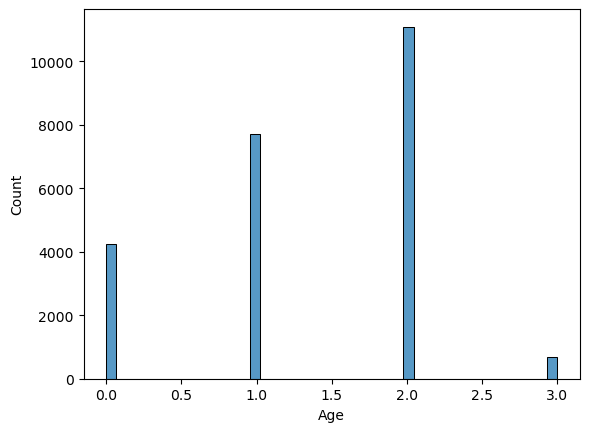

In [16]:
# Converting Age to Age_group
def age_group(age):
    if age >=0 and age < 18:
        return 0
    elif age < 30:
        return 1
    elif age < 80:
        return 2
    else:
        return 3
    
y = y.squeeze().apply(age_group)
sns.histplot(y)

In [17]:
# DataFrame to store the metrics values
metrics_values = pd.DataFrame(columns=['Original','Corr','Expon','Grid','Thres'],index=range(0,13))

# Original Model

In [18]:
# Model
inputs_dense = Input(shape=(10,))
x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
#x = Dropout(0.5)(x)
x = Dense(6, activation='relu', kernel_initializer='glorot_uniform')(x)
outputs_dense = Dense(4, activation='softmax', kernel_initializer='glorot_uniform')(x)
dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)

# Save Initial Weights
initial_weights = dense_model.get_weights()

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# CV and OOF Predictions
y_pred = pd.DataFrame(0,columns=[0,1,2,3],index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    
    inputs_dense = Input(shape=(10,))
    x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
    x = Dense(6, activation='relu', kernel_initializer='glorot_uniform')(x)
    outputs_dense = Dense(4, activation='softmax', kernel_initializer='glorot_uniform')(x)
    dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)
    dense_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Reinitialize the weights
    dense_model.set_weights(initial_weights)
    
    # Define early stopping
    es = EarlyStopping(monitor='val_loss', mode='min',patience=3)

    dense_model.fit(X_Train.values.astype('float32'), y_Train.values.astype('float32'),
                    epochs=25, batch_size=64, verbose=0,
                    validation_data=(X_Test.values.astype('float32'), y_Test.values.astype('float32')),
                    callbacks=[es])  
    preds = dense_model(X_Test.values.astype('float32')).numpy().squeeze()
    y_pred.loc[test_index,:] = preds
    
    scores.append(accuracy_score(y_Test.values.astype('float32'),np.argmax(preds,axis=1)))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')


# 0.7342332841172748
# 0.7449905083315757
# 0.7333895802573297
# 0.7308584686774942
# 0.7373971735920691
# Mean: 0.7361738029951488 
# STD:  0.004878549318893849 

0.6747521619911411
0.6764395697110315
0.6612529002320185
0.6570343809322927
0.6682134570765661
Mean: 0.66753849398861 
STD:  0.007504222947246723 



# Metrics

In [20]:
def multiclass_selection_rate(y_true, y_pred, desired_class):
    """Calculate the selection rate for a specific class in a multiclass classification problem.
    The selection rate is defined as the fraction of predicted labels that are equal to the desired class.
    Args:
        y_true : array-like
            The true labels.
        y_pred : array-like
            The predicted labels.
        desired_class : any
            The class for which to calculate the selection rate.
    Returns:
        float
            The selection rate for the desired class.
    """
    selected = (y_pred == desired_class).sum()
    total = y_pred.shape[0]
    return selected / total

In [21]:
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_ratio
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import pandas as pd

metrics = {
    'accuracy': lambda y_true, y_pred: accuracy_score(y_true, np.argmax(y_pred, axis=1)),
    'selection_rate_greater0': lambda y_true, y_pred: multiclass_selection_rate(y_true, np.argmax(y_pred, axis=1),0),
    'selection_rate_greater18': lambda y_true, y_pred: multiclass_selection_rate(y_true, np.argmax(y_pred, axis=1),1),
    'selection_rate_greater30': lambda y_true, y_pred: multiclass_selection_rate(y_true, np.argmax(y_pred, axis=1),2),
    'selection_rate_greater80': lambda y_true, y_pred: multiclass_selection_rate(y_true, np.argmax(y_pred, axis=1),3),
    'count': lambda y_true, y_pred: len(y_true),
}

### Table for Gender

#### Gender: {0: Female , 1: Male}
#### Ethnicity: {0: Asian , 1: Black , 2: Indian , 3: Others , 4: White}

In [22]:
# Create a MetricFrame object
mf = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=X[['Gender']])

# Compute the metrics for each group defined by the sensitive features
results = {}
for metric_name in metrics.keys():
        results[metric_name] = mf.by_group[metric_name]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df


,accuracy,selection_rate_greater0,selection_rate_greater18,selection_rate_greater30,selection_rate_greater80,count
Gender,,,,,,
0,0.626657,0.151405,0.468976,0.371575,0.008043,11314.0
1,0.704866,0.138488,0.154144,0.707368,0.000000,12391.0


### Table for Ethnicity

In [23]:
# Create a MetricFrame object
mf = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=X[['Ethnicity']])

# Compute the metrics for each group defined by the sensitive features
results = {}
for metric_name in metrics.keys():
        results[metric_name] = mf.by_group[metric_name]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

,accuracy,selection_rate_greater0,selection_rate_greater18,selection_rate_greater30,selection_rate_greater80,count
Ethnicity,,,,,,
0.0,0.706009,0.269021,0.494733,0.234686,0.001561,5126.0
1.0,0.586832,0.028281,0.464649,0.505745,0.001326,4526.0
2.0,0.674214,0.109434,0.337610,0.551698,0.001258,3975.0
4.0,0.681584,0.147549,0.122544,0.722762,0.007144,10078.0


### Table for Gender and Ethnicity

In [24]:
# Create a MetricFrame object
mf = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=X[['Gender','Ethnicity']])

# Compute the metrics for each group defined by the sensitive features
results = {}
for metric_name in metrics.keys():
        results[metric_name] = mf.by_group[metric_name]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

accuracy  selection_rate_greater0  selection_rate_greater18  \
Gender Ethnicity                                                                
0      0.0        0.720172                 0.256181                  0.639197   
       1.0        0.543025                 0.036232                  0.736866   
       2.0        0.633606                 0.127771                  0.595683   
       4.0        0.607477                 0.151923                  0.189959   
1      0.0        0.689079                 0.284368                  0.322056   
       1.0        0.628559                 0.020708                  0.205349   
       2.0        0.704998                 0.095533                  0.141973   
       4.0        0.743838                 0.143874                  0.065912   

                  selection_rate_greater30  selection_rate_greater80   count  
Gender Ethnicity                                                              
0      0.0                        0.101756                  0.002866  2791.0  
       1.0                        0.224185                  0.002717  2208.0  
       2.0                        0.273629                  0.002917  1714.0  
       4.0                        0.642469                  0.015649  4601.0  
1      0.0                        0.393576                  0.000000  2335.0  
       1.0                        0.773943                  0.000000  2318.0  
       2.0                        0.762494                  0.000000  2261.0  
       4.0                        0.790214                  0.000000  5477.0

### Demographic Parity

In [25]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, metric in enumerate(['accuracy',
               'selection_rate_greater0','selection_rate_greater18',
               'selection_rate_greater30','selection_rate_greater80']):

    mf = MetricFrame(
        metrics=metrics[metric],
        y_true=y,
        y_pred=y_pred,
        sensitive_features=X[['Gender','Ethnicity']]
    )

    dpr = mf.difference(method='between_groups')
    
    metrics_values.loc[i,'Original'] = dpr
    
    print(f'Based on {metric}:')
    print(f'Value of demographic parity difference: {round(dpr, 3)}\n')

Based on accuracy:
Value of demographic parity difference: 0.201

Based on selection_rate_greater0:
Value of demographic parity difference: 0.264

Based on selection_rate_greater18:
Value of demographic parity difference: 0.671

Based on selection_rate_greater30:
Value of demographic parity difference: 0.688

Based on selection_rate_greater80:
Value of demographic parity difference: 0.016



### Equalized Odds

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

def equalized_odds_difference(y_test, y_pred, target_class, sensitive_feature):
    tpr = []
    fpr = []
    df = pd.concat([y_test,pd.Series(y_pred),sensitive_feature],axis=1).reset_index(drop=True)
    df = df.rename({'Age':'y_test',0:'y_pred'},axis=1)

    for cls in sensitive_feature.value_counts().keys().values:
        # Convert multiclass problem to binary problem (one-vs-all)
        
        y_test_binary = df.loc[df[sensitive_feature.columns[0]] == cls,'y_test']
        y_pred_binary = df.loc[df[sensitive_feature.columns[0]] == cls,'y_pred']

        y_test_binary = (y_test_binary.values == target_class) * 1
        y_pred_binary = (y_pred_binary.values == target_class) * 1

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()

        # Calculate true positive rate and false positive rate
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))

    # Calculate equalized odds difference
    tpr_difference = max(tpr) - min(tpr)
    fpr_difference = max(fpr) - min(fpr)
    equalized_odds_difference = max(tpr_difference, fpr_difference)

    return equalized_odds_difference

In [27]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, sens_feat in enumerate(['Gender','Ethnicity']):
    print('---------------------------------------------------------------------------')
    print(f'Sensitive Feature: {sens_feat}:\n')
    for target_class, cls in enumerate(['Age_Group 0-18','Age_Group 18-30',
                                       'Age_Group 30-80','Age_Group 80-Inf']):

        eod = equalized_odds_difference(y,
                                        np.argmax(y_pred.values, axis=1), 
                                        target_class, 
                                        sensitive_feature=X[[sens_feat]])
        
        metrics_values.loc[target_class+(4*(i+1)+1),'Original'] = eod

        print(f'Based on {cls}:')
        print(f'Value of equal odds difference: {round(eod, 3)}\n')
    

---------------------------------------------------------------------------
Sensitive Feature: Gender:

Based on Age_Group 0-18:
Value of equal odds difference: 0.111

Based on Age_Group 18-30:
Value of equal odds difference: 0.386

Based on Age_Group 30-80:
Value of equal odds difference: 0.319

Based on Age_Group 80-Inf:
Value of equal odds difference: 0.114

---------------------------------------------------------------------------
Sensitive Feature: Ethnicity:

Based on Age_Group 0-18:
Value of equal odds difference: 0.476

Based on Age_Group 18-30:
Value of equal odds difference: 0.504

Based on Age_Group 30-80:
Value of equal odds difference: 0.393

Based on Age_Group 80-Inf:
Value of equal odds difference: 0.085



# Mitigation Algorithms

# Preprocessing Algorithms:

In [28]:
# Model
inputs_dense = Input(shape=(8,))
x = Dense(6, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
# x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(x)
outputs_dense = Dense(4, activation='softmax', kernel_initializer='glorot_uniform')(x)
dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)

# Save Initial Weights
initial_weights = dense_model.get_weights()

In [29]:
from fairlearn.preprocessing import CorrelationRemover

# CV and OOF Predictions
y_pred_1 = pd.DataFrame(0,columns=[0,1,2,3],index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    
    corr_remover = CorrelationRemover(sensitive_feature_ids=['Gender', 'Ethnicity'])
    corr_remover.fit(X_Train)
    X_Train = corr_remover.transform(X_Train)
    X_Test = corr_remover.transform(X_Test)
    
    inputs_dense = Input(shape=(8,))
    x = Dense(6, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
#     x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(x)
    outputs_dense = Dense(4, activation='softmax', kernel_initializer='glorot_uniform')(x)
    dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)
    dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)
    dense_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Reinitialize the weights
    dense_model.set_weights(initial_weights)
    
#      Define early stopping
    es = EarlyStopping(monitor='val_loss', mode='min',patience=3)
    
    dense_model.fit(X_Train.astype('float32'), y_Train.values.astype('float32'),
                    epochs=25, batch_size=64, verbose=0,
                    validation_data=(X_Test.astype('float32'), y_Test.astype('float32')),
                    callbacks=[es])
    preds = dense_model(X_Test.astype('float32')).numpy().squeeze()
    y_pred_1.loc[test_index,:] = preds
    
    scores.append(accuracy_score(y_Test.values.astype('float32'),np.argmax(preds,axis=1)))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')

0.6439569711031428
0.6262391900442944
0.6184349293398017
0.6277156717991985
0.6357308584686775
Mean: 0.630415524151023 
STD:  0.008716526668218809 



In [30]:
y_pred_1.to_csv('y_pred_Corr.csv',index=False)

#### Demographic Parity and Equalized Odds:

In [31]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, metric in enumerate(['accuracy',
               'selection_rate_greater0','selection_rate_greater18',
               'selection_rate_greater30','selection_rate_greater80']):

    mf = MetricFrame(
        metrics=metrics[metric],
        y_true=y,
        y_pred=y_pred_1,
        sensitive_features=X[['Gender','Ethnicity']]
    )

    dpr = mf.difference(method='between_groups')
    
    metrics_values.loc[i,'Corr'] = dpr
    
    print(f'Based on {metric}:')
    print(f'Value of demographic parity difference: {round(dpr, 3)}\n')

Based on accuracy:
Value of demographic parity difference: 0.177

Based on selection_rate_greater0:
Value of demographic parity difference: 0.276

Based on selection_rate_greater18:
Value of demographic parity difference: 0.305

Based on selection_rate_greater30:
Value of demographic parity difference: 0.495

Based on selection_rate_greater80:
Value of demographic parity difference: 0.001



In [32]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, sens_feat in enumerate(['Gender','Ethnicity']):
    print('---------------------------------------------------------------------------')
    print(f'Sensitive Feature: {sens_feat}:\n')
    for target_class, cls in enumerate(['Age_Group 0-18','Age_Group 18-30',
                                       'Age_Group 30-80','Age_Group 80-Inf']):

        eod = equalized_odds_difference(y,
                                        np.argmax(y_pred_1.values, axis=1), 
                                        target_class, 
                                        sensitive_feature=X[[sens_feat]])
        
        metrics_values.loc[target_class+(4*(i+1)+1),'Corr'] = eod

        print(f'Based on {cls}:')
        print(f'Value of equal odds difference: {round(eod, 3)}\n')
    

---------------------------------------------------------------------------
Sensitive Feature: Gender:

Based on Age_Group 0-18:
Value of equal odds difference: 0.079

Based on Age_Group 18-30:
Value of equal odds difference: 0.227

Based on Age_Group 30-80:
Value of equal odds difference: 0.202

Based on Age_Group 80-Inf:
Value of equal odds difference: 0.004

---------------------------------------------------------------------------
Sensitive Feature: Ethnicity:

Based on Age_Group 0-18:
Value of equal odds difference: 0.506

Based on Age_Group 18-30:
Value of equal odds difference: 0.237

Based on Age_Group 30-80:
Value of equal odds difference: 0.338

Based on Age_Group 80-Inf:
Value of equal odds difference: 0.009



# In-processing Algorithms:

In [33]:
# Model
inputs_dense = Input(shape=(10,))
x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
x = Dense(4, activation='relu', kernel_initializer='glorot_uniform')(x)
outputs_dense = Dense(2, activation='softmax', kernel_initializer='glorot_uniform')(x)
dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)

# Save Initial Weights
initial_weights = dense_model.get_weights()

#### Exponentiated Gradient

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from tensorflow.keras.optimizers import Adam

class DeepLearningEstimator:
    def __init__(self, model, initial_weights):
        self.model = model
        self.initial_weights = initial_weights

    def fit(self, X, y, sample_weight=None):
        es = EarlyStopping(monitor='val_loss', mode='min',patience=3)    
        self.model.fit(X.astype('float32'), y.astype('float32'), sample_weight=sample_weight, epochs=25, batch_size=64, verbose=0,
                       validation_data=(X_Test.values.astype('float32'), y_Test.values.astype('float32')),
                       callbacks=[es])

    def predict(self, X):
        return self.model(X.astype('float32')).numpy().squeeze()[:,1]

# CV and OOF Predictions
y_pred_2 = pd.DataFrame(0,columns=[0,1,2,3],index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=3).split(X, y):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    
    # Create a deep learning estimator
    inputs_dense = Input(shape=(10,))
    x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
    x = Dense(4, activation='relu', kernel_initializer='glorot_uniform')(x)
    outputs_dense = Dense(2, activation='softmax', kernel_initializer='glorot_uniform')(x)
    dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)
    dense_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    dense_model.set_weights(initial_weights)
    dl_estimator = DeepLearningEstimator(dense_model, initial_weights)

    # ExponentiatedGradient (one-vs-all)
    expgrad_estimators = []
    classes = [0,1,2,3]
    for cls in classes:
        # Convert multiclass problem to binary problem (one-vs-all)
        y_Train_binary = (y_Train == cls) * 1

        # ExponentiatedGradient
        expgrad = ExponentiatedGradient(dl_estimator, constraints=EqualizedOdds(), max_iter=70)
        expgrad.fit(X_Train.values.astype('float32'), y_Train_binary.values.astype('float32'),
                    sensitive_features=X_Train[['Gender','Ethnicity']])
        expgrad_estimators.append(expgrad)
    
    # Generate predictions for each class (OOF Probabilities)
    for i, expgrad in enumerate(expgrad_estimators):
        y_pred_2.loc[test_index,i] = expgrad.predict(X_Test.values)
    
    scores.append(accuracy_score(y_Test.values.astype('float32'),np.argmax(y_pred_2.loc[test_index,:].values,axis=1).astype('float32')))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')


In [ ]:
y_pred_2.to_csv('y_pred_expGrad.csv',index=False)

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, metric in enumerate(['accuracy',
               'selection_rate_greater0','selection_rate_greater18',
               'selection_rate_greater30','selection_rate_greater80']):

    mf = MetricFrame(
        metrics=metrics[metric],
        y_true=y,
        y_pred=y_pred_2,
        sensitive_features=X[['Gender','Ethnicity']]
    )

    dpr = mf.difference(method='between_groups')
    
    metrics_values.loc[i,'Expon'] = dpr
    
    print(f'Based on {metric}:')
    print(f'Value of demographic parity difference: {round(dpr, 3)}\n')

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, sens_feat in enumerate(['Gender','Ethnicity']):
    print('---------------------------------------------------------------------------')
    print(f'Sensitive Feature: {sens_feat}:\n')
    for target_class, cls in enumerate(['Age_Group 0-18','Age_Group 18-30',
                                       'Age_Group 30-80','Age_Group 80-Inf']):

        eod = equalized_odds_difference(y,
                                        np.argmax(y_pred_2.values, axis=1), 
                                        target_class, 
                                        sensitive_feature=X[[sens_feat]])
        
        metrics_values.loc[target_class+(4*(i+1)+1),'Expon'] = eod

        print(f'Based on {cls}:')
        print(f'Value of equal odds difference: {round(eod, 3)}\n')
    

#### Grid Search

In [34]:
from fairlearn.reductions import DemographicParity, GridSearch, EqualizedOdds
from tensorflow.keras.optimizers import Adam

class DeepLearningEstimator:
    def __init__(self, model, initial_weights):
        self.model = model
        self.initial_weights = initial_weights

    def fit(self, X, y, sample_weight=None):
        es = EarlyStopping(monitor='val_loss', mode='min',patience=3)    
        self.model.fit(X.astype('float32'), y.astype('float32'), sample_weight=sample_weight, epochs=25, batch_size=64, verbose=0,
                       validation_data=(X_Test.values.astype('float32'), y_Test.values.astype('float32')),
                       callbacks=[es])

    def predict(self, X):
        return self.model(X.astype('float32')).numpy().squeeze()[:,1]

# CV and OOF Predictions
y_pred_3 = pd.DataFrame(0,columns=[0,1,2,3],index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=3).split(X, y):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    
    # Create a deep learning estimator
    inputs_dense = Input(shape=(10,))
    x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
    x = Dense(4, activation='relu', kernel_initializer='glorot_uniform')(x)
    outputs_dense = Dense(2, activation='softmax', kernel_initializer='glorot_uniform')(x)
    dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)
    dense_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    dense_model.set_weights(initial_weights)
    dl_estimator = DeepLearningEstimator(dense_model, initial_weights)

    # ExponentiatedGradient (one-vs-all)
    grid_estimators = []
    classes = [0,1,2,3]
    for cls in classes:
        # Convert multiclass problem to binary problem (one-vs-all)
        y_Train_binary = (y_Train == cls) * 1

        # Grid Search
        grid = GridSearch(dl_estimator, constraints=EqualizedOdds(), grid_size=40)
        grid.fit(X_Train.values.astype('float32'), y_Train_binary.values.astype('float32'),
                    sensitive_features=X_Train[['Gender','Ethnicity']])
        grid_estimators.append(grid)
    
    # Generate predictions for each class (OOF Probabilities)
    for i, grid in enumerate(grid_estimators):
        y_pred_3.loc[test_index,i] = grid.predict(X_Test.values)
    
    scores.append(accuracy_score(y_Test.values.astype('float32'),np.argmax(y_pred_3.loc[test_index,:].values,axis=1).astype('float32')))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')


0.3163756011136421
0.4683624398886358
0.5686621946589039
Mean: 0.45113341188706063 
STD:  0.1037135827654775 



In [35]:
y_pred_3.to_csv('y_pred_gridsearch.csv',index=False)

In [36]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, metric in enumerate(['accuracy',
               'selection_rate_greater0','selection_rate_greater18',
               'selection_rate_greater30','selection_rate_greater80']):

    mf = MetricFrame(
        metrics=metrics[metric],
        y_true=y,
        y_pred=y_pred_3,
        sensitive_features=X[['Gender','Ethnicity']]
    )

    dpr = mf.difference(method='between_groups')
    
    metrics_values.loc[i,'Grid'] = dpr
    
    print(f'Based on {metric}:')
    print(f'Value of demographic parity difference: {round(dpr, 3)}\n')

Based on accuracy:
Value of demographic parity difference: 0.301

Based on selection_rate_greater0:
Value of demographic parity difference: 0.335

Based on selection_rate_greater18:
Value of demographic parity difference: 0.404

Based on selection_rate_greater30:
Value of demographic parity difference: 0.505

Based on selection_rate_greater80:
Value of demographic parity difference: 0.244



In [37]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, sens_feat in enumerate(['Gender','Ethnicity']):
    print('---------------------------------------------------------------------------')
    print(f'Sensitive Feature: {sens_feat}:\n')
    for target_class, cls in enumerate(['Age_Group 0-18','Age_Group 18-30',
                                       'Age_Group 30-80','Age_Group 80-Inf']):

        eod = equalized_odds_difference(y,
                                        np.argmax(y_pred_3.values, axis=1), 
                                        target_class, 
                                        sensitive_feature=X[[sens_feat]])
        
        metrics_values.loc[target_class+(4*(i+1)+1),'Grid'] = eod

        print(f'Based on {cls}:')
        print(f'Value of equal odds difference: {round(eod, 3)}\n')
    

---------------------------------------------------------------------------
Sensitive Feature: Gender:

Based on Age_Group 0-18:
Value of equal odds difference: 0.232

Based on Age_Group 18-30:
Value of equal odds difference: 0.163

Based on Age_Group 30-80:
Value of equal odds difference: 0.139

Based on Age_Group 80-Inf:
Value of equal odds difference: 0.453

---------------------------------------------------------------------------
Sensitive Feature: Ethnicity:

Based on Age_Group 0-18:
Value of equal odds difference: 0.223

Based on Age_Group 18-30:
Value of equal odds difference: 0.299

Based on Age_Group 30-80:
Value of equal odds difference: 0.442

Based on Age_Group 80-Inf:
Value of equal odds difference: 0.19



# Postprocessing Algorithms:

In [38]:
# Model
inputs_dense = Input(shape=(10,))
x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
x = Dense(4, activation='relu', kernel_initializer='glorot_uniform')(x)
outputs_dense = Dense(2, activation='softmax', kernel_initializer='glorot_uniform')(x)
dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)

# Save Initial Weights
initial_weights = dense_model.get_weights()

In [41]:
from fairlearn.reductions import DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer

from tensorflow.keras.optimizers import Adam

class DeepLearningEstimator:
    def __init__(self, model, initial_weights):
        self.model = model
        self.initial_weights = initial_weights

    def fit(self, X, y, sample_weight=None):
        es = EarlyStopping(monitor='val_loss', mode='min',patience=3)    
        self.model.fit(X.astype('float32'), y.astype('float32'), sample_weight=sample_weight, epochs=25, batch_size=64, verbose=0,
                       validation_data=(X_Test.values.astype('float32'), y_Test.values.astype('float32')),
                       callbacks=[es])
        self.is_fitted_ = True  
    def predict(self, X):
        return self.model(X.astype('float32')).numpy().squeeze()[:,1]

    def get_params(self, deep=True):
        return {'model': self.model, 'initial_weights': self.initial_weights}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# CV and OOF Predictions
y_pred_4 = pd.DataFrame(0,columns=[0,1,2,3],index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    inputs_dense = Input(shape=(10,))
    x = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(inputs_dense)
    x = Dense(4, activation='relu', kernel_initializer='glorot_uniform')(x)
    outputs_dense = Dense(2, activation='softmax', kernel_initializer='glorot_uniform')(x)
    dense_model = Model(inputs=inputs_dense, outputs=outputs_dense)
    dense_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    dense_model.set_weights(initial_weights)
    dl_estimator = DeepLearningEstimator(dense_model, initial_weights)
    
    # Threshold Optimizer (one-vs-all)
    threshopt_estimators = []
    classes = [0,1,2,3]
    for cls in classes:
        # Convert multiclass problem to binary problem (one-vs-all)
        y_Train_binary = (y_Train == cls) * 1
        
        # Create a deep learning estimator
        dl_estimator.fit(X_Train.values.astype('float32'), y_Train_binary.values.astype('float32'))
        
        # Threshold Optimizer
        threshopt = ThresholdOptimizer(estimator=dl_estimator, constraints='equalized_odds',
                                       prefit=True, predict_method='auto', grid_size=5000)
        threshopt.fit(X_Train.values.astype('float32'), y_Train_binary.values.astype('float32'), 
                      sensitive_features=X_Train[['Ethnicity','Gender']])
        threshopt_estimators.append(threshopt)
    
    
    # Generate predictions for each class
    for i, threshopt in enumerate(threshopt_estimators):
        y_pred_4.loc[test_index,i] = threshopt.predict(X_Test.values.astype('float32'), sensitive_features=X_Test[['Gender','Ethnicity']], random_state=42)
    
    scores.append(accuracy_score(y_Test.values.astype('float32'),np.argmax(y_pred_4.loc[test_index,:].values,axis=1).astype('float32')))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')


# Gridsize = 1000
# 0.1845602193630036
# 0.19215355410251003
# 0.1858257751529213
# 0.18962244252267454
# 0.19194262813752372
# Mean: 0.18882092385572663 
# STD:  0.0031182819848262103 


# Gridsize = 5000
# 0.18603670111790763
# 0.1864585530478802
# 0.1883568867327568
# 0.18793503480278423
# 0.19152077620755115
# Mean: 0.188061590381776 
# STD:  0.00193592810049926 

0.18603670111790763
0.1864585530478802
0.1883568867327568
0.18793503480278423
0.19152077620755115
Mean: 0.188061590381776 
STD:  0.00193592810049926 



In [ ]:
y_pred_4.to_csv('y_pred_Threshold.csv',index=False)

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, metric in enumerate(['accuracy',
               'selection_rate_greater0','selection_rate_greater18',
               'selection_rate_greater30','selection_rate_greater80']):

    mf = MetricFrame(
        metrics=metrics[metric],
        y_true=y,
        y_pred=y_pred_4,
        sensitive_features=X[['Gender','Ethnicity']]
    )

    dpr = mf.difference(method='between_groups')
    
    metrics_values.loc[i,'Thres'] = dpr
    
    print(f'Based on {metric}:')
    print(f'Value of demographic parity difference: {round(dpr, 3)}\n')

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

for i, sens_feat in enumerate(['Gender','Ethnicity']):
    print('---------------------------------------------------------------------------')
    print(f'Sensitive Feature: {sens_feat}:\n')
    for target_class, cls in enumerate(['Age_Group 0-18','Age_Group 18-30',
                                       'Age_Group 30-80','Age_Group 80-Inf']):

        eod = equalized_odds_difference(y,
                                        np.argmax(y_pred_4.values, axis=1), 
                                        target_class, 
                                        sensitive_feature=X[[sens_feat]])
        
        metrics_values.loc[target_class+(4*(i+1)+1),'Thres'] = eod

        print(f'Based on {cls}:')
        print(f'Value of equal odds difference: {round(eod, 3)}\n')
    

In [ ]:
metrics_values.to_csv('Metrics_Values.csv',index=False)

# Plot for Comparison:

## Demographic Parities

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# creating the dataset
metric_1 = {'Original':metrics_values.loc[0,'Original']*100,
            'Corr':metrics_values.loc[0,'Corr']*100,
            'Expon':metrics_values.loc[0,'Expon']*100, 
            'Grid':metrics_values.loc[0,'Grid']*100,
            'Thres':metrics_values.loc[0,'Thres']*100}
metric_2 = {'Original':metrics_values.loc[1,'Original']*100,
            'Corr':metrics_values.loc[1,'Corr']*100,
            'Expon':metrics_values.loc[1,'Expon']*100, 
            'Grid':metrics_values.loc[1,'Grid']*100,
            'Thres':metrics_values.loc[1,'Thres']*100}
metric_3 = {'Original':metrics_values.loc[2,'Original']*100,
            'Corr':metrics_values.loc[2,'Corr']*100,
            'Expon':metrics_values.loc[2,'Expon']*100, 
            'Grid':metrics_values.loc[2,'Grid']*100,
            'Thres':metrics_values.loc[2,'Thres']*100}
metric_4 = {'Original':metrics_values.loc[3,'Original']*100,
            'Corr':metrics_values.loc[3,'Corr']*100,
            'Expon':metrics_values.loc[3,'Expon']*100, 
            'Grid':metrics_values.loc[3,'Grid']*100,
            'Thres':metrics_values.loc[3,'Thres']*100}
metric_5 = {'Original':metrics_values.loc[4,'Original']*100,
            'Corr':metrics_values.loc[4,'Corr']*100,
            'Expon':metrics_values.loc[4,'Expon']*100, 
            'Grid':metrics_values.loc[4,'Grid']*100,
            'Thres':metrics_values.loc[4,'Thres']*100}

#Values of Metrics   
metric_1 = list(metric_1.values())
metric_2 = list(metric_2.values())
metric_3 = list(metric_3.values())
metric_4 = list(metric_4.values())
metric_5 = list(metric_5.values())

#Define the plot
fig = plt.subplots(figsize =(15, 8))

#Define the Distances
br1 = np.arange(5)
br2 = [x + 0.15 for x in br1]
br3 = [x + 0.15 for x in br2]
br4 = [x + 0.15 for x in br3]
br5 = [x + 0.15 for x in br4]

#Create the bar plot
plt.bar(br1, metric_1, color ='darkred', width = 0.15,
        edgecolor ='black', label ='Accuracy')
plt.bar(br2, metric_2, color ='g', width = 0.15,
        edgecolor ='black', label ='SR_0')
plt.bar(br3, metric_3, color ='darkblue', width = 0.15,
        edgecolor ='black', label ='SR_18')
plt.bar(br4, metric_4, color ='gray', width = 0.15,
        edgecolor ='black', label ='SR_30')
plt.bar(br5, metric_5, color ='purple', width = 0.15,
        edgecolor ='black', label ='SR_80')

#Name the of The x-axis
plt.xticks([r + 0.20 for r in range(5)],
        ['Original', 'Corr', 'Expon', 'Grid','Thres'])

#y-axis Boundaries
plt.ylim((0,60))

plt.xlabel("Models Used")
plt.ylabel("Performance")
plt.title("Comparison Between the Demographic Parities of Each Model")
plt.legend()
plt.show()


## Equalized Odds (Gender)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# creating the dataset
metric_1 = {'Original':metrics_values.loc[5,'Original']*100,
            'Corr':metrics_values.loc[5,'Corr']*100,
            'Expon':metrics_values.loc[5,'Expon']*100, 
            'Grid':metrics_values.loc[5,'Grid']*100,
            'Thres':metrics_values.loc[5,'Thres']*100}
metric_2 = {'Original':metrics_values.loc[6,'Original']*100,
            'Corr':metrics_values.loc[6,'Corr']*100,
            'Expon':metrics_values.loc[6,'Expon']*100, 
            'Grid':metrics_values.loc[6,'Grid']*100,
            'Thres':metrics_values.loc[6,'Thres']*100}
metric_3 = {'Original':metrics_values.loc[7,'Original']*100,
            'Corr':metrics_values.loc[7,'Corr']*100,
            'Expon':metrics_values.loc[7,'Expon']*100, 
            'Grid':metrics_values.loc[7,'Grid']*100,
            'Thres':metrics_values.loc[7,'Thres']*100}
metric_4 = {'Original':metrics_values.loc[8,'Original']*100,
            'Corr':metrics_values.loc[8,'Corr']*100,
            'Expon':metrics_values.loc[8,'Expon']*100, 
            'Grid':metrics_values.loc[8,'Grid']*100,
            'Thres':metrics_values.loc[8,'Thres']*100}

#Values of Metrics   
metric_1 = list(metric_1.values())
metric_2 = list(metric_2.values())
metric_3 = list(metric_3.values())
metric_4 = list(metric_4.values())

#Define the plot
fig = plt.subplots(figsize =(15, 8))

#Define the Distances
br1 = np.arange(5)
br2 = [x + 0.15 for x in br1]
br3 = [x + 0.15 for x in br2]
br4 = [x + 0.15 for x in br3]

#Create the bar plot
plt.bar(br1, metric_1, color ='darkred', width = 0.15,
        edgecolor ='black', label ='EO_0')
plt.bar(br2, metric_2, color ='g', width = 0.15,
        edgecolor ='black', label ='EO_18')
plt.bar(br3, metric_3, color ='darkblue', width = 0.15,
        edgecolor ='black', label ='EO_30')
plt.bar(br4, metric_4, color ='gray', width = 0.15,
        edgecolor ='black', label ='EO_80')

#Name the of The x-axis
plt.xticks([r + 0.20 for r in range(5)],
        ['Original', 'Corr', 'Expon', 'Grid','Thres'])

#y-axis Boundaries
plt.ylim((0,40))

plt.xlabel("Models Used")
plt.ylabel("Performance")
plt.title("Comparison Between the Equalized Odds (Gender) of Each Model")
plt.legend()
plt.show()


## Equalized Odds (Ethnicity)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# creating the dataset
metric_1 = {'Original':metrics_values.loc[9,'Original']*100,
            'Corr':metrics_values.loc[9,'Corr']*100,
            'Expon':metrics_values.loc[9,'Expon']*100, 
            'Grid':metrics_values.loc[9,'Grid']*100,
            'Thres':metrics_values.loc[9,'Thres']*100}
metric_2 = {'Original':metrics_values.loc[10,'Original']*100,
            'Corr':metrics_values.loc[10,'Corr']*100,
            'Expon':metrics_values.loc[10,'Expon']*100, 
            'Grid':metrics_values.loc[10,'Grid']*100,
            'Thres':metrics_values.loc[10,'Thres']*100}
metric_3 = {'Original':metrics_values.loc[11,'Original']*100,
            'Corr':metrics_values.loc[11,'Corr']*100,
            'Expon':metrics_values.loc[11,'Expon']*100, 
            'Grid':metrics_values.loc[11,'Grid']*100,
            'Thres':metrics_values.loc[11,'Thres']*100}
metric_4 = {'Original':metrics_values.loc[12,'Original']*100,
            'Corr':metrics_values.loc[12,'Corr']*100,
            'Expon':metrics_values.loc[12,'Expon']*100, 
            'Grid':metrics_values.loc[12,'Grid']*100,
            'Thres':metrics_values.loc[12,'Thres']*100}

#Values of Metrics   
metric_1 = list(metric_1.values())
metric_2 = list(metric_2.values())
metric_3 = list(metric_3.values())
metric_4 = list(metric_4.values())

#Define the plot
fig = plt.subplots(figsize =(15, 8))

#Define the Distances
br1 = np.arange(5)
br2 = [x + 0.15 for x in br1]
br3 = [x + 0.15 for x in br2]
br4 = [x + 0.15 for x in br3]

#Create the bar plot
plt.bar(br1, metric_1, color ='darkred', width = 0.15,
        edgecolor ='black', label ='EO_0')
plt.bar(br2, metric_2, color ='g', width = 0.15,
        edgecolor ='black', label ='EO_18')
plt.bar(br3, metric_3, color ='darkblue', width = 0.15,
        edgecolor ='black', label ='EO_30')
plt.bar(br4, metric_4, color ='gray', width = 0.15,
        edgecolor ='black', label ='EO_80')

#Name the of The x-axis
plt.xticks([r + 0.20 for r in range(5)],
        ['Original', 'Corr', 'Expon', 'Grid','Thres'])

#y-axis Boundaries
plt.ylim((0,45))

plt.xlabel("Models Used")
plt.ylabel("Performance")
plt.title("Comparison Between the Equalized Odds (Ethnicity) of Each Model")
plt.legend()
plt.show()
